<p style="background-color:mediumseagreen;font-family:newtimeroman;font-size:200%;color:white;text-align:center;border-radius:60px 20px;"><b>XGBoost Regression</b></p>

**About Dataset**

- **Car_Name**: The name or model of the car.
- **Year**: The year of manufacture of the car.
- **Selling_Price**: The selling price of the car.
- **Present_Price**: The current showroom price of the car.
- **Kms_Driven**: The total kilometers driven by the car up to the point of sale.
- **Fuel_Type**: This column would contain categories such as:
  - **Petrol**: Cars that run on petrol fuel.
  - **Diesel**: Cars that use diesel fuel.
  - **CNG**: Cars that are powered by compressed natural gas.

- **Seller_Type**: This column would indicate the type of seller offering the car, which could be:
  - **Dealer**: A business that sells cars as part of its commercial operations.
  - **Individual**: A private individual selling a personal vehicle.

- **Transmission**: This refers to the gearbox system of the car, with common types being:
  - **Manual**: Cars where the driver manually shifts gears.
  - **Automatic**: Cars where the gear shifting process is automated.

- **Owner**: This would typically be a numeric column indicating the number of previous owners of the car, but if it is categorical, it might have entries such as:
  - **First Owner**: Indicates the car is being sold by its original owner.
  - **Second Owner**: Indicates the car has had one previous owner before the current seller.
  - **Third Owner**, and so on.
  
This data set is for estimating the selling price of a car based on its features.

# <font color='mediumseagreen'> <b>Importing Libraries</b><font color='black'>  

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

plt.rcParams["figure.figsize"] = (9,5)

import warnings
warnings.filterwarnings('ignore')

# <font color='mediumseagreen'> <b>Loading The Dataset</b><font color='black'>  

In [120]:
df0 = pd.read_csv("car_dataset.csv")
df = df0.copy()

In [121]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


# <font color='mediumseagreen'> <b>Understanding Data & EDA</b><font color='black'>  

In [123]:
df.shape

(301, 9)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [125]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


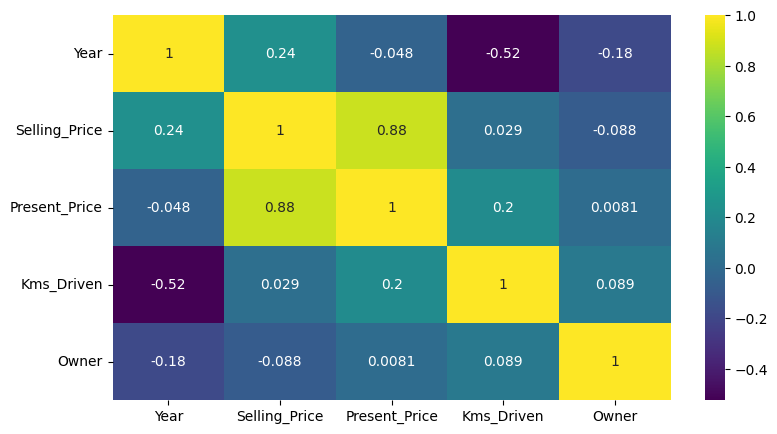

In [127]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.show()

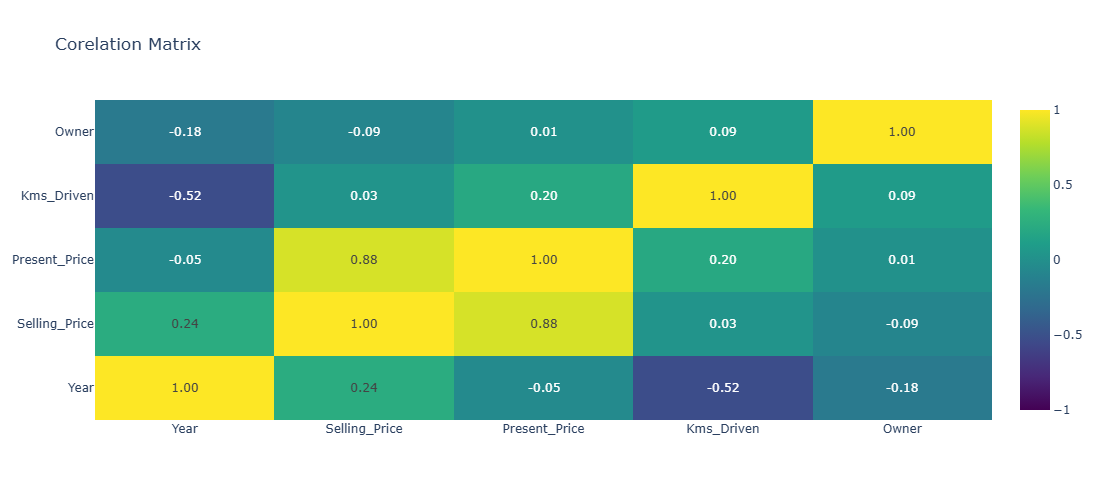

In [128]:
# another correlation matrix

import plotly.graph_objects as go

corr_matrix = df.select_dtypes(include='number').corr()
heatmap = go.Heatmap(
    z=corr_matrix.values, x=corr_matrix.columns, y=corr_matrix.index,
    colorscale='viridis', zmin=-1, zmax=1, text=corr_matrix.values,
    texttemplate="%{text:.2f}", hoverinfo="none"
)

fig = go.Figure(data=[heatmap], layout=go.Layout(
    title='Corelation Matrix', width=700, height=500))
fig.show()

In [129]:
df["Vehicle_Age"] = 2024 - df.Year

# Converting the vehicle production year in the data set to "age" feature.

In [130]:
def unique_values(df, columns):
    """Prints unique values and their counts for specific columns in the DataFrame."""

    for column_name in columns:
        print(f"Column: {column_name}\n{'-'*30}")
        unique_vals = df[column_name].unique()
        value_counts = df[column_name].value_counts()
        print(f"Unique Values ({len(unique_vals)}): {unique_vals}\n")
        print(f"Value Counts:\n{value_counts}\n{'='*40}\n")

In [131]:
cat_features = df.select_dtypes(include='object').columns
unique_values(df, cat_features)

# Seeing how many unique observations categorical features consist of.
# The number of unique categorical observations of car_name is very high compared to the total number of observations in the data set.

Column: Car_Name
------------------------------
Unique Values (98): ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift' 'vitara brezza' 's cross'
 'alto 800' 'ertiga' 'dzire' 'alto k10' 'ignis' '800' 'baleno' 'omni'
 'fortuner' 'innova' 'corolla altis' 'etios cross' 'etios g' 'etios liva'
 'corolla' 'etios gd' 'camry' 'land cruiser' 'Royal Enfield Thunder 500'
 'UM Renegade Mojave' 'KTM RC200' 'Bajaj Dominar 400'
 'Royal Enfield Classic 350' 'KTM RC390' 'Hyosung GT250R'
 'Royal Enfield Thunder 350' 'KTM 390 Duke ' 'Mahindra Mojo XT300'
 'Bajaj Pulsar RS200' 'Royal Enfield Bullet 350'
 'Royal Enfield Classic 500' 'Bajaj Avenger 220' 'Bajaj Avenger 150'
 'Honda CB Hornet 160R' 'Yamaha FZ S V 2.0' 'Yamaha FZ 16'
 'TVS Apache RTR 160' 'Bajaj Pulsar 150' 'Honda CBR 150' 'Hero Extreme'
 'Bajaj Avenger 220 dtsi' 'Bajaj Avenger 150 street' 'Yamaha FZ  v 2.0'
 'Bajaj Pulsar  NS 200' 'Bajaj Pulsar 220 F' 'TVS Apache RTR 180'
 'Hero Passion X pro' 'Bajaj Pulsar NS 200' 'Yamaha Fazer '
 'Honda Activa 4G' 'TVS 

In [132]:
df.drop(columns=["Car_Name", "Year"], inplace=True)

In [133]:
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,10
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,11
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,7
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,13
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,10


In [134]:
df.Transmission.unique()

array(['Manual', 'Automatic'], dtype=object)

<Figure size 1200x600 with 0 Axes>

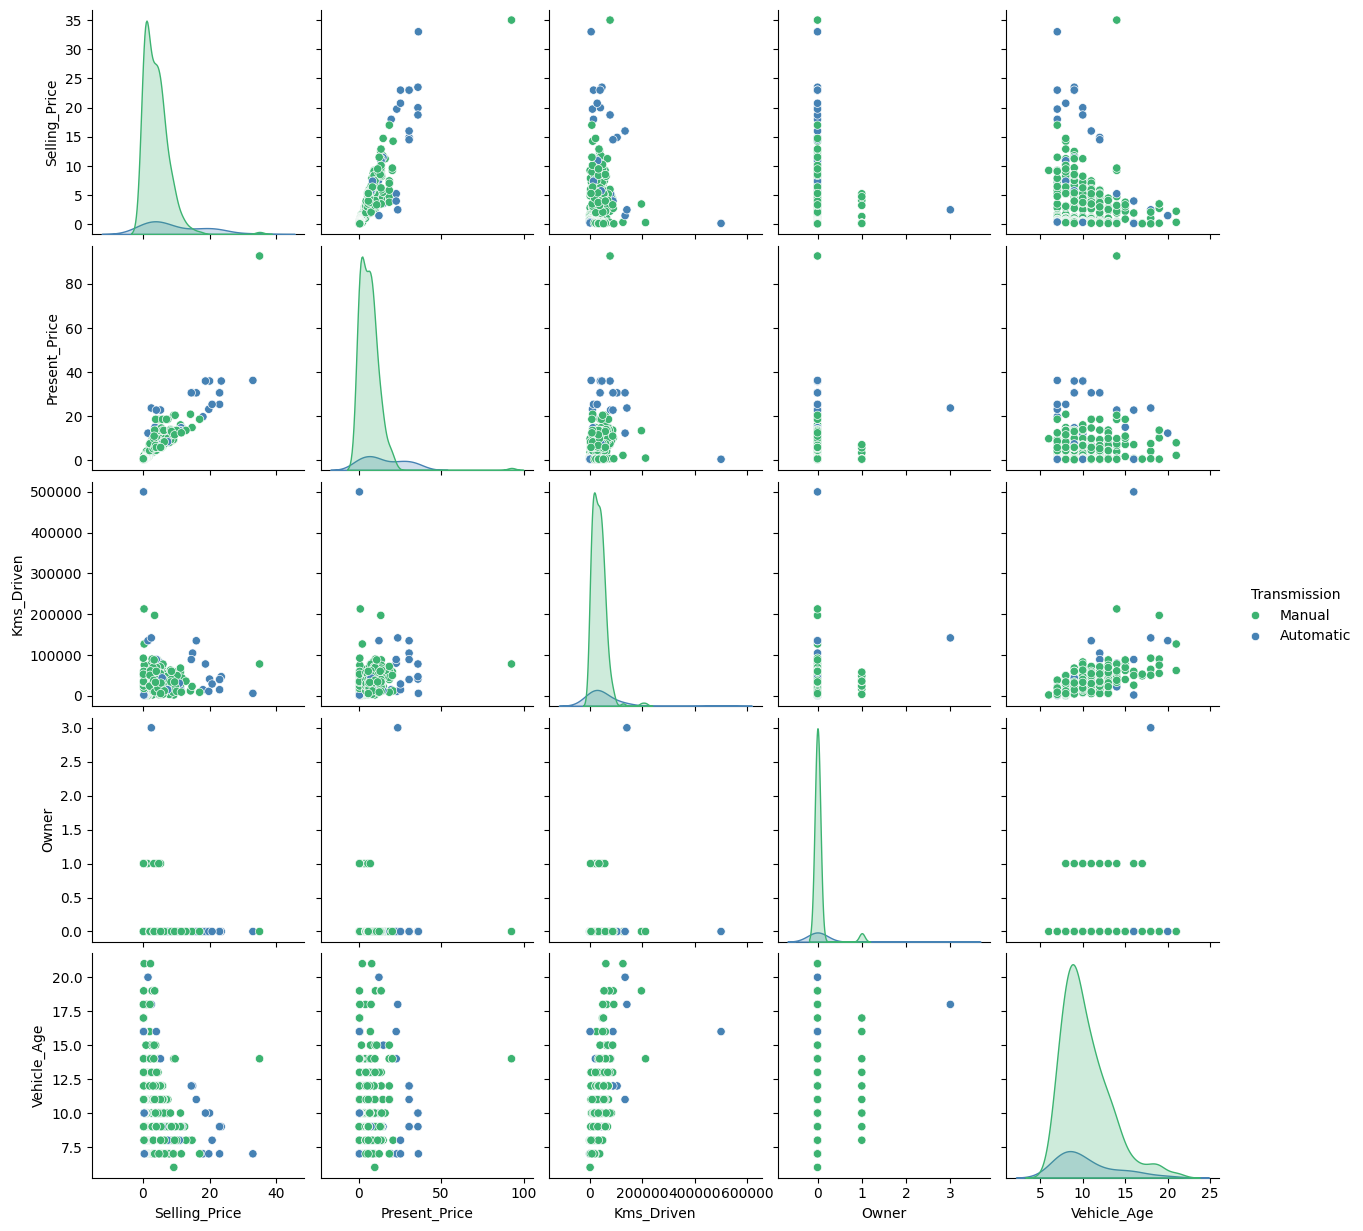

In [135]:
plt.figure(figsize=(12, 6))
sns.pairplot(df, hue="Transmission", palette=["mediumseagreen", "steelblue"])
plt.show()

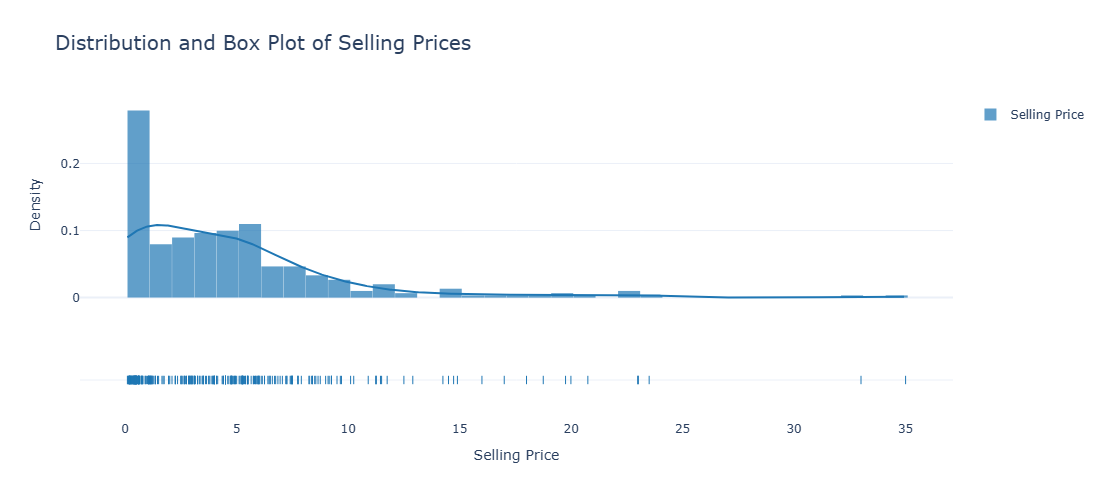

In [136]:
import plotly.figure_factory as ff

fig = ff.create_distplot([df['Selling_Price']], ['Selling Price'],
                         show_hist=True,
                         show_rug=True)

fig.update_layout(
    title_text='Distribution and Box Plot of Selling Prices',
    title_font_size=20,
    xaxis_title_text='Selling Price',
    yaxis_title_text='Density',
    template='plotly_white',
    width=1000,
    height=500,
    bargap=0.01,
)

fig.show()

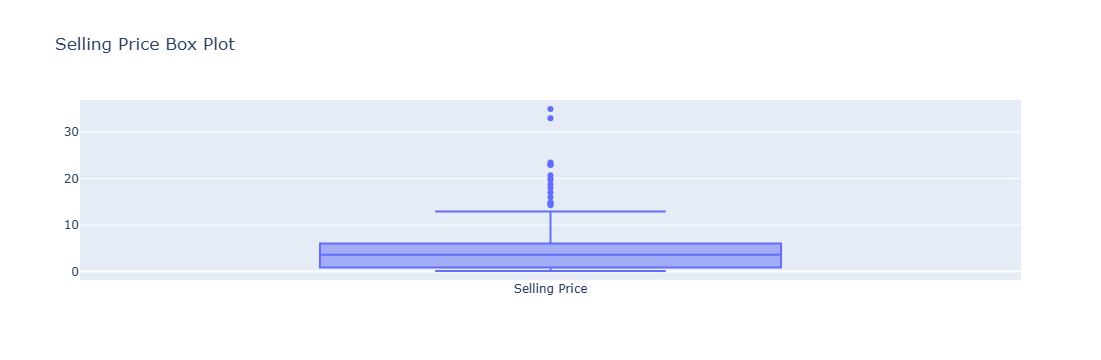

In [137]:
import plotly.graph_objs as go

box_plot = go.Box(y=df['Selling_Price'], name='Selling Price')

fig = go.Figure(data=[box_plot])
fig.update_layout(title='Selling Price Box Plot')
fig.show()

# <font color='mediumseagreen'> <b>Modeling</b><font color='black'>  

## <font color='limegreen'> <b>Train | Test Split</b><font color='black'>  

In [140]:
df2 = df[df.Selling_Price < 10]
df2.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,10
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,11
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,7
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,13
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,10


In [141]:
X=df2.drop("Selling_Price", axis=1)
y=df2.Selling_Price

In [142]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=101)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (218, 7)
Train target shape   :  (218,)
Test features shape  :  (55, 7)
Test target shape    :  (55,)


In [143]:
cat_features = X.select_dtypes("object").columns
cat_features 

Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')

In [144]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat_features), remainder='passthrough')

In [145]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

## <font color='limegreen'> <b>XGBoost Regressor</b><font color='black'>  

**Overview**
XGBoost stands for eXtreme Gradient Boosting and is an advanced gradient boosting algorithm. It is popular for its high performance and speed, and it can effectively work on large-scale and complex datasets.

**Key Features**
- **High Performance**: Effective in both speed and model accuracy.
- **Scalability**: Can handle large datasets.
- **Flexibility**: Offers various customization and configuration options.

**Important Parameters**
- **n_estimators:** The total number of trees.
- **learning_rate:** Controls the size of adjustments made at each step.
- **max_depth:** The maximum depth of the trees.
- **subsample:** The fraction of random samples used for each tree.
- **colsample_bytree:** The fraction of random columns (features) used for each tree.
- **objective:** The target function to be optimized.

**Use Cases**
- **Price Prediction**: Price prediction in areas like real estate, stock market, and second-hand products.
- **Demand Forecasting**: Used in sales, marketing, and supply chain optimization.
- **Risk Assessment**: Risk prediction in finance and insurance sectors.

---

- **XGBoost:**
  - Both classification (XGBClassifier) and regression (XGBRegressor) use loss functions that are determined by the model's objective parameter. For classification, options like binary:logistic, multi:softmax are available, while for regression, options like "reg:squarederror", "reg:linear" are offered.

In [148]:
operations = [("OrdinalEncoder", column_trans), ("XGB_model", XGBRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

# While objective='binary:logistic' in classification, it is 'reg:squarederror' in regression. 
# other parameters are the same as classification.

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('XGB_model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_by...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=101, reg_alpha=0,
                              reg_lambda=1, ...))])

In [149]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.999998,0.962817
mae,0.002585,0.363464
mse,0.000016,0.304429
rmse,0.003957,0.551751


## <font color='limegreen'> <b>Cross Validation</b><font color='black'>  

In [151]:
operations = [("OrdinalEncoder", column_trans), ("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =5,
                       return_train_score=True)
pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              0.925007
train_r2                             0.999999
test_neg_mean_absolute_error        -0.453708
train_neg_mean_absolute_error       -0.001702
test_neg_mean_squared_error         -0.501656
train_neg_mean_squared_error        -0.000007
test_neg_root_mean_squared_error    -0.694818
train_neg_root_mean_squared_error   -0.002512
dtype: float64

## <font color='limegreen'> <b>GridSearchCV</b><font color='black'>  

**XGBoost Regressor Key Parameters and Functions**

**n_estimators**: The total number of sequential trees to be created. More trees generally lead to better performance but can increase the risk of overfitting.

**learning_rate**: Determines the learning rate and controls the contribution of each tree to the training process. A lower value typically results in slower learning but better generalization performance.

**max_depth**: The maximum depth of each tree. As depth increases, the model can learn more complex relationships but also increases the risk of overfitting.

**min_child_weight**: The minimum sum of weights of all examples required to create a child node. Used to prevent overfitting.

**gamma**: The minimum loss reduction required for further tree splits. Helps prevent unnecessary tree growth and reduces overfitting.

**subsample**: The fraction of samples to be used for each tree. Smaller values can reduce overfitting, but very low values may increase bias.

**colsample_bytree**: The fraction of features to be used for each tree. Ensures that each tree is created using different features.

**alpha**: L1 regularization term (alpha). Reduces model complexity and helps prevent overfitting.

**reg_lambda**: L2 regularization term (lambda). Reduces model complexity and helps prevent overfitting.

**scale_pos_weight**: Weight factor for imbalanced classes. Ensures better generalization on imbalanced datasets.

**objective**: The target function to optimize. reg:squarederror (mean squared error), reg:logistic (logistic regression).

**booster**: The type of model to use. gbtree (tree-based models), gblinear (linear models).

**Application Notes**
- The performance of XGBoost depends on the selected parameters, so it is important to adjust parameters appropriately for the dataset and problem.
- Parameters should be carefully chosen to redce the risk of overfitting.


In [154]:
param_grid = {
    "XGB_model__n_estimators": [40, 50, 100],
    "XGB_model__max_depth": [2, 3],
    "XGB_model__learning_rate": [0.01, 0.05, 0.06],
    "XGB_model__subsample": [0.5, 0.8, 1],
    "XGB_model__colsample_bytree": [0.5, 0.8, 1]
}

In [155]:
operations = [("OrdinalEncoder", column_trans), ("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=5,
                          n_jobs = -1,
                          return_train_score=True)
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                                       ('XGB_model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsamp...
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=101,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'XGB_model__colsample_bytree': [0.5, 0.8, 1],
                         'XGB_model__learning_rate': [0.01, 0.05, 0.06],
                         'XGB_model__max_depth': [2, 3],
                         'XGB_model__n_estimators': [40, 50, 100],
                         'XGB_model__subsample': [0.5, 0.8, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [156]:
grid_model.best_params_

{'XGB_model__colsample_bytree': 1,
 'XGB_model__learning_rate': 0.06,
 'XGB_model__max_depth': 3,
 'XGB_model__n_estimators': 100,
 'XGB_model__subsample': 0.8}

In [157]:
grid_model.best_score_

-0.5935698466912293

In [158]:
y_pred = grid_model.predict(X_test)
XGB_R2 = r2_score(y_test, y_pred)
XGB_mae = mean_absolute_error(y_test, y_pred)
XGB_mse = mean_squared_error(y_test, y_pred)
XGB_rmse = mean_squared_error(y_test, y_pred, squared=False)
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.983610,0.970807
mae,0.242953,0.332463
mse,0.113062,0.239007
rmse,0.336247,0.488883


## <font color='limegreen'> <b>Feature Importance</b><font color='black'>  

In [160]:
operations = [("OrdinalEncoder", column_trans),
              ("XGB_model",
               XGBRegressor(n_estimators=100,
                            learning_rate=0.06,
                            max_depth=3,
                            random_state=101,
                            subsample=0.5))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('XGB_model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_by...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.06, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=101, reg_alpha=0,
                              reg_lambda=1, ...))])

In [161]:
pipe_model["XGB_model"].feature_importances_

array([0.04789568, 0.2052371 , 0.01382258, 0.5158294 , 0.05286758,
       0.00647596, 0.15787177], dtype=float32)

In [162]:
pipe_model["OrdinalEncoder"].get_feature_names_out()

array(['ordinalencoder__Fuel_Type', 'ordinalencoder__Seller_Type',
       'ordinalencoder__Transmission', 'remainder__Present_Price',
       'remainder__Kms_Driven', 'remainder__Owner',
       'remainder__Vehicle_Age'], dtype=object)

In [163]:
features = pipe_model["OrdinalEncoder"].get_feature_names_out()
features

array(['ordinalencoder__Fuel_Type', 'ordinalencoder__Seller_Type',
       'ordinalencoder__Transmission', 'remainder__Present_Price',
       'remainder__Kms_Driven', 'remainder__Owner',
       'remainder__Vehicle_Age'], dtype=object)

In [164]:
new_features = [i.replace("ordinalencoder__","").replace("remainder__", "") for i in features]
new_features

['Fuel_Type',
 'Seller_Type',
 'Transmission',
 'Present_Price',
 'Kms_Driven',
 'Owner',
 'Vehicle_Age']

In [165]:
imp_feats = pd.DataFrame(data=pipe_model["XGB_model"].feature_importances_, columns=['XGB_Importance'], index=new_features)
xgb_imp_feats = imp_feats.sort_values('XGB_Importance', ascending=False)
xgb_imp_feats

,XGB_Importance
Present_Price,0.515829
Seller_Type,0.205237
Vehicle_Age,0.157872
Kms_Driven,0.052868
Fuel_Type,0.047896
Transmission,0.013823
Owner,0.006476


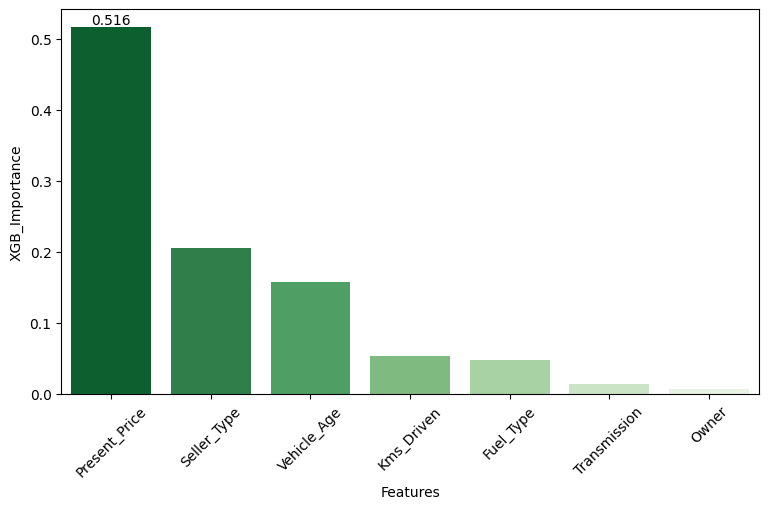

In [166]:
ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y='XGB_Importance', palette= 'Greens_r')
ax.bar_label(ax.containers[0],fmt="%.3f")

plt.xticks(rotation=45)
plt.xlabel("Features");

<p style="background-color:mediumseagreen;font-family:newtimeroman;font-size:200%;color:white;text-align:center;border-radius:60px 20px;"><b>THANK YOU!</b></p>